Using P1 elements in 1D gives the absolute error: 1.305622e-13 

Using P1 elements in 2D gives the absolute error: 2.140510e-13 

Using P1 elements in 3D gives the absolute error: 3.641532e-14 

h=0.1000, E/h=0.1488, N=3 

h=0.0500, E/h=0.1267, N=4 

h=0.0250, E/h=0.1187, N=6 

h=0.0125, E/h=0.1086, N=8 

h=0.0063, E/h=0.1075, N=12 

h=0.0031, E/h=0.1052, N=17 

h=0.0016, E/h=0.1054, N=25 

h=0.0008, E/h=0.1041, N=35 



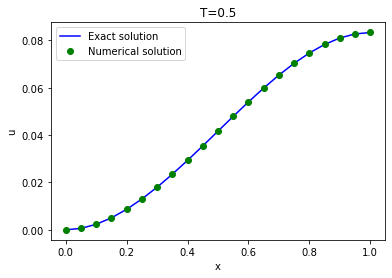

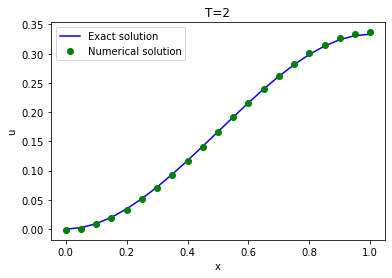

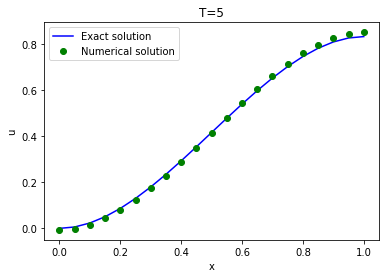

In [4]:
import matplotlib.pyplot as plt
from fenics import *
import numpy as np

def solver(N, I, f, alpha, rho, dt, T, P):
    """ 
    N: A list containg number of points in each direction, i.e [8,8,8] for 3D.
    I: An array of the initial condition 
    f: The source term
    alpha: Might be a constant or a known function depending on u
    P: Degree of finite elements
    """
    def create_mesh(N):
        # Create mesh and define function space
        dim = len(N)
        if dim == int(1):
            #print('1D')
            mesh = UnitIntervalMesh(N[0])
        elif dim == int(2):
            #print('2D')
            mesh = UnitSquareMesh(N[0], N[1])
        else:
            #print('3D')
            mesh = UnitCubeMesh(N[0], N[1], N[2])
        return mesh

    
    # Create mesh and define function space
    mesh = create_mesh(N)
    V = FunctionSpace(mesh, 'P', P)
    
    # Define initial value
    u_1 = interpolate(I,V)
    
    # Define variational problem
    u = TrialFunction(V)
    v = TestFunction(V)
    
    a = (u*v + dt/rho*inner(alpha(u_1)*nabla_grad(u), nabla_grad(v)))*dx
    L = (u_1*v + (dt/rho)*f*v)*dx
    
    # Time-stepping
    u = Function(V)
    t=0
    num_steps = int(T/dt)
    for n in range(num_steps):
        # Update current time
        t += dt
        I.t = t
        f.t = t
        
        # Compute solution
        solve(a == L, u)
        
        # Update previous solution
        u_1.assign(u)    
        
    return u_1, V


def task_d():
    """
    Testing a constant solution
    """
    I = Expression("7", degree=1) 
    alpha = lambda u: 2
    f = Constant('0')
    T = 1; dt = 0.1
    rho = 1; P = 1
    interval, square, box = [8], [8,8], [8,8,8]
    
    for N in interval, square, box:
        u, V = solver(N, I, f, alpha, rho, dt, T, P)
        u_e = interpolate(I, V)
        error = np.abs(u_e.vector().get_local() - u.vector().get_local()).max()        
        print('Using P%d elements in %dD gives the absolute error: %e \n' %(P, len(N), error))

        
        
def task_e():
    """
    Testing analytical solution
    """
    I = Expression("cos(pi*x[0])", degree=1)
    alpha = lambda u: 1
    f = Constant('0')
    T = 0.5; dt = 0.1
    rho = 1; P = 1
    u_N = Expression('exp(-pi*pi*t)*cos(pi*x[0])', t=T, degree=1)    
    
    for round in range(8):
        h = dt
        N = [int(1./np.sqrt(dt)), int(1./np.sqrt(dt))]
        u, V = solver(N, I, f, alpha, rho, dt, T, P)
        u_e = interpolate(u_N, V)
        e = u_e.vector().get_local() - u.vector().get_local()
        E = np.sqrt((np.sum(e**2))/u.vector().get_local().size)
        print('h=%.4f, E/h=%.4f, N=%d \n' %(h, float(E)/h, N[0]))
        dt /= 2

        
def task_f():
    N = [20]; dt = 0.5
    rho = 1; P = 1
    
    I = Constant('0')
    u_N = Expression('t*pow(x[0],2)*(0.5 - x[0]/3.)', t=0, degree=3)
    alpha = lambda u: 1 + u**2
    f = Expression('-rho*pow(x[0],3)/3 + rho*pow(x[0],2)/2 + 8*pow(t,3)*pow(x[0],7)/9 - \
                    28*pow(t,3)*pow(x[0],6)/9 + 7*pow(t,3)*pow(x[0],5)/2 - \
                    5*pow(t,3)*pow(x[0],4)/4 + 2*t*x[0] - t', rho=rho, t=0, degree=1)
    
    
    for T in [0.5, 2, 5]:
        u, V = solver(N, I, f, alpha, rho, dt, T, P)
        u_N.t = T
        u_e = interpolate(u_N, V)
        
        x = np.linspace(0, 1, 20+1)
        plt.plot(x, u_e.vector().get_local()[::-1], 'b')
        plt.plot(x, u.vector().get_local()[::-1], 'go')
        plt.legend(['Exact solution','Numerical solution'])
        plt.xlabel('x')
        plt.ylabel('u')
        plt.title('T=%s' %T)
        plt.show()

        
if __name__ == '__main__':    
    task_d()        
    task_e()
    task_f()